# What is LightGBM?

LightGBM is a tree based algorithm that grows trees in depth-first or leaf-wise fashion

![leaf-wise](images/lgbm_depth_first.png)

as opposed to the standard implementation of tree based algorithms, which grow in breadth-first or level-wise fashion

![level-wise](images/lgbm_breadth_first.png)

image credit: [LightGBM docs](https://lightgbm.readthedocs.io/en/latest/Features.html) 

### Claimed Advantages
- The name 'Light' refers to its high speed
- Handles the large size of data, taking less memory to do so
- Focuses on the accuracy of results
- Supports GPU learning

### Claimed Disadvantages
- Prone to overfitting on smaller datasets

### Installation
```
conda install -c conda-forge lightgbm
```

# Python API

If you are familiar with scikit-learn I would recommend using that API as a frontend. Your intuition about tree based algorithms can immedately be applied in this case. On other hand, the Data Structure and Training APIs are more general, and are fairly easy to pick up -- comparable to Keras IMO. 

### Data Structure
- `Dataset`: Dataset in LightGBM.
- `Booster`: Booster in LightGBM.

### Training
- `train`: Perform the training with given parameters.
- `cv`: Perform the cross-validation with given paramaters.

### scikit-learn
- `LGBMModel`: Implementation of the scikit-learn API for LightGBM.
- `LGBMClassifier`: LightGBM classifier.
- `LGBMRegressor`: LightGBM regressor.
- `LGBMRanker`: LightGBM ranker.

### Callbacks
- `early_stopping`: Create a callback that activates early stopping.
- `print_evaluation`: Create a callback that prints the evaluation results.
- `record_evaluation`: Create a callback that records the evaluation history into `eval_result`.
- `reset_parameter`: Create a callback that resets the parameter after the first iteration.

### Plotting
- `plot_importance`: Plot model’s feature importances.
- `plot_metric`: Plot one metric during training.
- `plot_tree`: Plot specified tree.
- `create_tree_digraph`: Create a digraph representation of specified tree.

# Example using scikit-learn

### Dataset
Let's reuse the largest dataset from our class imbalance study

In [1]:
from imblearn.datasets import fetch_datasets

In [2]:
protein_homo = fetch_datasets('datasets/')['protein_homo']

### Data Processing

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
X = protein_homo['data']
y = protein_homo['target']

In [5]:
print(X.shape)

(145751, 74)


In [6]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, stratify=y)

### Model Building and Training

In [7]:
from lightgbm import LGBMClassifier

In [8]:
lgbmc = LGBMClassifier(max_depth=10)

In [9]:
from time import time

In [10]:
t_tr = time()
lgbmc.fit(X_tr, y_tr)
print('Training time = %0.2f sec.' %(time()-t_tr))

Training time = 3.86 sec.


### Model Predictions

In [11]:
t_te = time()
lgbmc_pred = lgbmc.predict_proba(X_te)
print('Scoring time = %0.2f sec.' %(time()-t_te))

Scoring time = 0.14 sec.


In [12]:
from sklearn.metrics import average_precision_score

In [14]:
average_precision_score(y_te, lgbmc_pred[:,1])

0.869606253503309

### Compare against a standard decision tree

In [15]:
from sklearn.ensemble import GradientBoostingClassifier

In [16]:
gbc = GradientBoostingClassifier(max_depth=10)

In [17]:
t_tr = time()
gbc.fit(X_tr, y_tr)
print('Training time = %0.2f sec.' %(time()-t_tr))

Training time = 506.25 sec.


In [18]:
t_te = time()
y_probas = gbc.predict_proba(X_te)
print('Scoring time = %0.2f sec.' %(time()-t_te))

Scoring time = 0.12 sec.


In [19]:
average_precision_score(y_te, y_probas[:,1])

0.8076519376319254

### Result

- LightGBM was the overwhelming winner in terms of training time, finishing more than _100 times_ faster than the standard gradient boosting classifier. (In a previous iteration of this notebook it was 200x faster)
- LightGBM also scored higher by a decent margin. Some of this difference may or may not be made up with by hyperparameter tuning, but out-of-the-box performance makes one take this algorithm seriously

### Plotting
Let's check out these plotting functions.

In [22]:
import matplotlib.pyplot as plt

In [20]:
from lightgbm import plot_importance

It appears that `plot_importance` is only plotting function that can be used out-of-the-box with the scikit-learn API

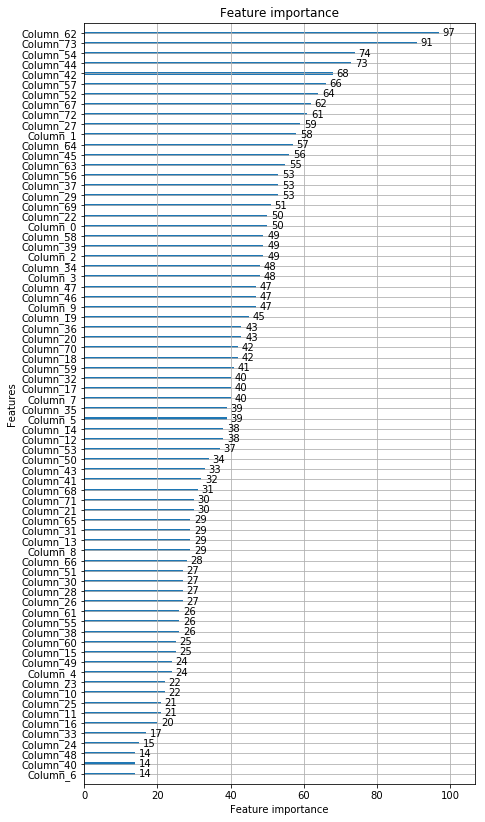

In [29]:
ax = plot_importance(lgbmc, figsize=(7, 14))
plt.show()

# Example w/o scikit-learn

Now let's work through the same example, but this time without using the scikit-learn API

In [5]:
from imblearn.datasets import fetch_datasets

In [6]:
protein_homo = fetch_datasets('datasets/')['protein_homo']

In [20]:
X = protein_homo['data']

For binary classification LightGBM requires the targets to be 0s or 1s

In [12]:
y = (protein_homo['target'] == 1)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, stratify=y)

We need to convert the training data into the LightGBM Dataset format

In [9]:
import lightgbm as lgb

In [13]:
d_train = lgb.Dataset(X_tr, label=y_tr)

In [14]:
params = {'objective':'binary',
          'max_depth':10,
          'metric':'binary_logloss'}

In [15]:
clf = lgb.train(params, d_train)

Note that with the Data Structure API `clf.predict()` returns a list of probabilities, whereas in scikit-learn it is `clf.predict_proba()` that returns a list of probabilities while `clf.predict()` returns a list of predicted classes

In [17]:
y_probas = clf.predict(X_te)

In [18]:
from sklearn.metrics import average_precision_score

In [19]:
average_precision_score(y_te, y_probas)

0.8719168441193899

### Add in Early Stopping

Now let's add in early stopping

First, we need to format the test dataset

In [27]:
d_valid = d_train.create_valid(X_te, label=y_te)

Create a dictionary to store our training results

In [58]:
val_results = dict()

Set the validation metric to ROC AUC. (Average Precision is not an option)

In [70]:
params['metric'] = 'auc'

The default number of iterations is 100. I've increased it to 300 to increase the chances of seeing the effect of early stopping

In [76]:
clf = lgb.train(params,
                d_train,
                num_boost_round=300,
                valid_sets=d_valid,
                valid_names='test',
                early_stopping_rounds=10,
                evals_result=val_results)

/Users/christopherwmurphy/anaconda/lib/python3.6/site-packages/lightgbm/engine.py:121: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	test's auc: 0.876911
Training until validation scores don't improve for 10 rounds.
[2]	test's auc: 0.930218
[3]	test's auc: 0.955419
[4]	test's auc: 0.960017
[5]	test's auc: 0.959621
[6]	test's auc: 0.961481
[7]	test's auc: 0.963547
[8]	test's auc: 0.965809
[9]	test's auc: 0.969142
[10]	test's auc: 0.967725
[11]	test's auc: 0.968306
[12]	test's auc: 0.970613
[13]	test's auc: 0.97081
[14]	test's auc: 0.974823
[15]	test's auc: 0.976668
[16]	test's auc: 0.976307
[17]	test's auc: 0.975705
[18]	test's auc: 0.975541
[19]	test's auc: 0.976044
[20]	test's auc: 0.975717
[21]	test's auc: 0.975649
[22]	test's auc: 0.977421
[23]	test's auc: 0.977697
[24]	test's auc: 0.97769
[25]	test's auc: 0.977644
[26]	test's auc: 0.977632
[27]	test's auc: 0.977504
[28]	test's auc: 0.977133
[29]	test's auc: 0.977408
[30]	test's auc: 0.977513
[31]	test's auc: 0.977889
[32]	test's auc: 0.977747
[33]	test's auc: 0.977814
[34]	test's auc: 0.978334
[35]	test's auc: 0.979002
[36]	test's auc: 0.979011
[37]	test's a

In [77]:
y_probas = clf.predict(X_te)

The AP improve slightly by training for more iterations while being careful not to overfit

In [78]:
average_precision_score(y_te, y_probas)

0.8794139530994048

### Visualize Training

In [74]:
import matplotlib.pyplot as plt
from lightgbm import plot_metric

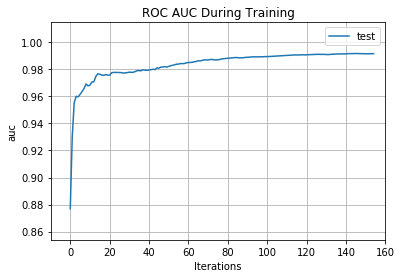

In [81]:
ax = plot_metric(val_results,
                 title='ROC AUC During Training',
                 xlim=(-10, 160))
plt.show()

# Parallel Learning

See the parallel learning [guide](https://lightgbm.readthedocs.io/en/latest/Parallel-Learning-Guide.html) for training on multiple machines